In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning


pressure=1
diffusion="nodiff"

hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_1bar_smear_1.h5", "MC/hits")
# hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_1bar_smear_2638.h5", "MC/hits")
# hits = pd.read_hdf("../data/TrackReco/ATPC_Bi_1bar_nexus_filtered.h5", "MC/hits"); hits["z"] = hits["z"]+3000

# hits = pd.read_hdf("../data/ATPC_Tl/ATPC_Tl_1bar_smear_1.h5", "MC/hits")

# hits = pd.read_hdf("../data/Trackreco/ATPC_Tl_1bar_nodiff_reco.h5", "data")


# hits = pd.read_hdf("../data/test/test.h5", "MC/hits")

display(hits)
event_list = hits.event_id.unique()
print(event_list)


,event_id,x,y,z,energy
0,300,89.615318,-939.863159,955.390076,0.001612
1,300,91.906059,-935.204834,956.500061,0.001463
2,300,88.367668,-944.717957,956.973877,0.001017
3,300,92.731934,-933.711548,957.157471,0.000595
4,300,93.129417,-932.968079,957.531433,0.000050
...,...,...,...,...,...
61347,359,-360.404266,-1859.765991,3375.439453,0.012152
61348,359,-365.006500,-1860.799927,3376.175293,0.015847
61349,359,-367.853821,-1863.795044,3376.409912,0.007490
61350,359,-367.820679,-1862.214722,3378.310547,0.002207


[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353
 354 355 356 357 358 359]


,event_id,x,y,z,energy
4097,304,1298.266724,-627.244141,4528.946289,0.000124
4098,304,1301.069702,-629.018677,4529.365723,0.000694
4099,304,1305.073975,-631.846069,4530.083984,0.001339
4100,304,1294.245972,-624.970825,4530.262695,0.000918
4101,304,1307.574341,-633.909363,4530.987793,0.000496
...,...,...,...,...,...
5063,304,1558.949951,-695.009949,5161.089355,0.004935
5064,304,1551.051147,-696.645325,5161.630859,0.001339
5065,304,1553.790405,-695.362122,5161.666016,0.001438
5066,304,1548.429810,-698.270874,5161.900879,0.000794


Diffussion smear is:  0.1 mm/sqrt(cm)
Energy threshold is:  0.0 keV
diffision scale factor is:  7
Radius scale factor is:  7
Voxel scale factor is:  2.1
Tortuosity distance scale is: 70.0
mean_sigma: 15
Total groups created: 3


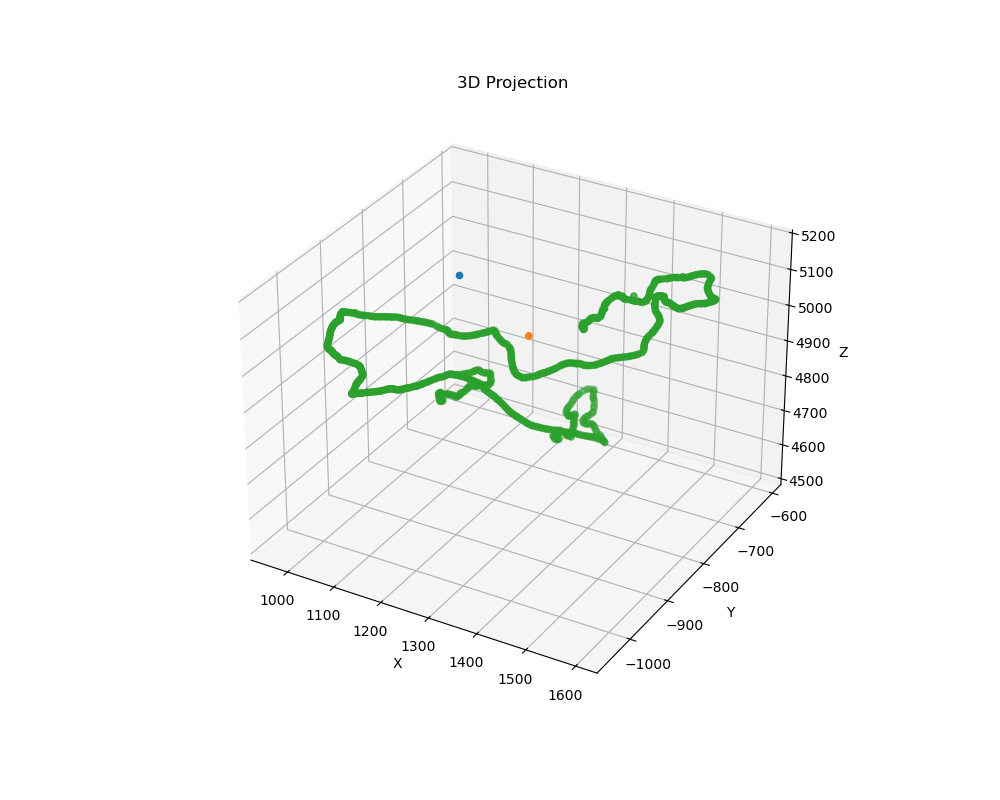

In [67]:
%matplotlib widget

data = hits[hits.event_id ==event_list[4]]
# data = hits[hits.event_id ==395909]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

display(data)
# eid = data.event_id.item()
data = data[['event_id', 'x', 'y', 'z',"energy"]]


# Apply grouping
Diff_smear, energy_threshold, diff_scale_factor, radius_sf, voxel_sf, Tortuosity_dist = InitializeParams(pressure, diffusion)

print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Voxel scale factor is: ",      voxel_sf)
print("Tortuosity distance scale is:", Tortuosity_dist)

mean_sigma = round(diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean()))
print("mean_sigma:", mean_sigma)

# Calculate the detector half-length
det_size = int(np.cbrt(6000**3/pressure)/2.0) 

# This shifts the z pos of the events so 0 is at anode
z_shift = det_size

zmin=-det_size + z_shift - mean_sigma/2 
xmin=-det_size - mean_sigma/2 
ymin=-det_size - mean_sigma/2 

reco_DE_event = data.copy()

# voxel size and parameters
voxel_size = mean_sigma  # mm
threshold = voxel_size*voxel_sf

data = GroupHits(reco_DE_event, xmin, ymin, zmin, voxel_size, threshold)

# If we have too many groups then bump up the voxel size since the track was broken too much
if (len(data.group_id.unique()) > 10):
    print("Running grouping again")
    data = GroupHits(reco_DE_event, xmin, ymin, zmin, voxel_size, voxel_size*(voxel_sf+1))


# Apply energy threshold and redistribute energy
data = CutandRedistibuteEnergy(data, energy_threshold)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for gid in sorted(data.group_id.unique()):
    temp_df = data[data.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='o')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



,event_id,x,y,z,energy,group_id
0,304,966.004333,-896.833008,5022.678223,0.000074,2
1,304,966.107361,-900.664124,5026.140625,0.001513,2
2,304,966.664978,-902.179260,5027.728516,0.000223,2
3,304,966.851929,-894.626831,5020.670898,0.001686,2
4,304,967.339661,-903.379700,5029.088867,0.000422,2
...,...,...,...,...,...,...
966,304,1594.702271,-722.199280,5131.250977,0.004786,2
967,304,1595.167969,-731.854614,5132.962891,0.000670,2
968,304,1595.587646,-729.752441,5132.249512,0.002034,2
969,304,1595.742188,-726.576904,5132.854004,0.027875,2


Median distance to the closest row: 2.6268279035141524


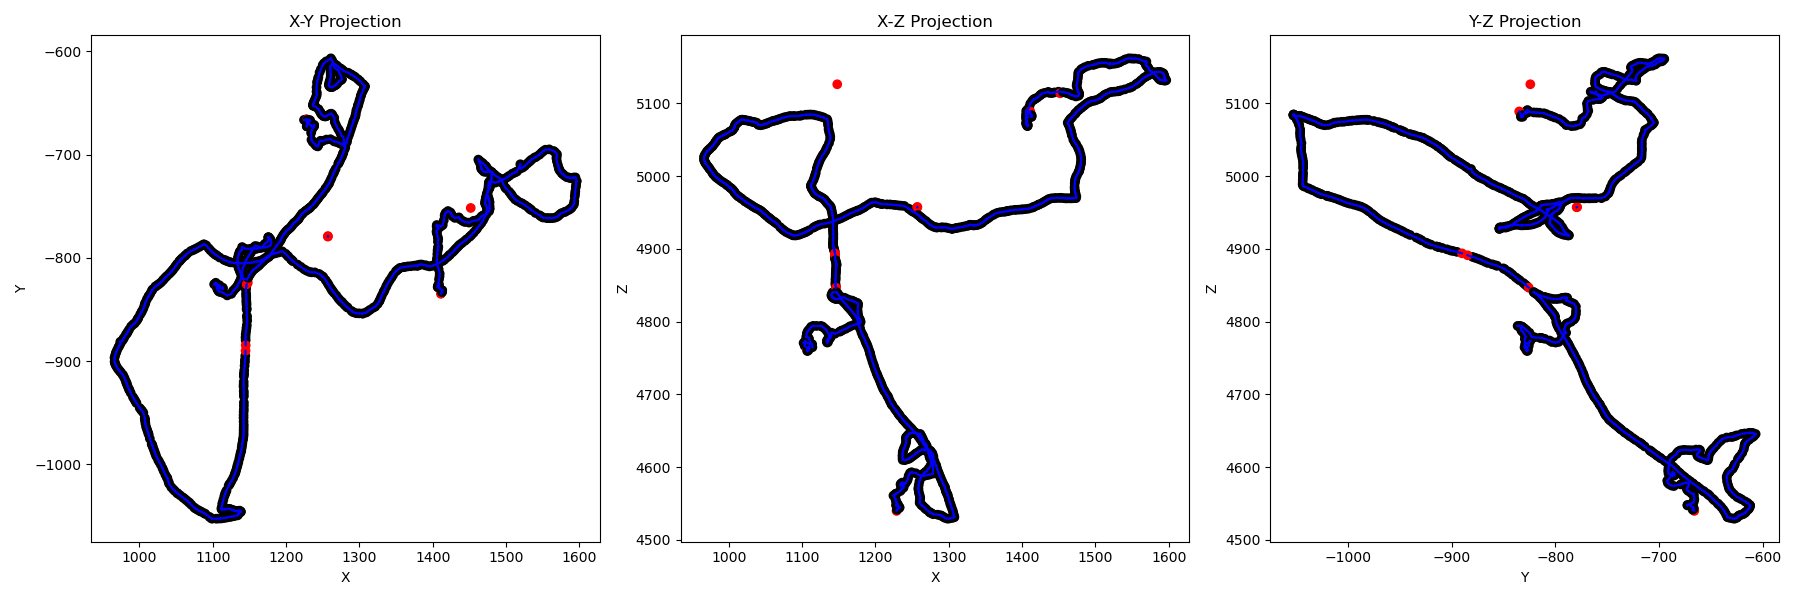

In [68]:




# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}
connections = []

# Tunable parameters
Meadian_dist = GetMedianNodeDistances(data) # Median distance between nodes
init_dist_thresh = Meadian_dist*2 # max distance for initial connections [mm]
incr_dist_thresh = np.linspace(1, Meadian_dist*7, 15, dtype=int) # Second stage, look for closest nodes, then slowly increase threshold [mm]
incr_dist_thresh = np.unique(incr_dist_thresh)

dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]


for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection, the connection is within the dist threshold and is within the same group
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh and CheckSameGroup(data, i, closest_idx)):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is <=1, also that the proposed node is in the same group
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []) and CheckSameGroup(data, i, closest_idx): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break


# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_17745/518107878.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('Dark2')


{'id': 0, 'start': 154, 'end': 452, 'nodes': [154, 156, 162, 166, 163, 155, 146, 148, 144, 147, 158, 168, 177, 178, 164, 161, 151, 153, 157, 160, 167, 172, 180, 194, 205, 209, 212, 216, 222, 224, 233, 244, 247, 256, 254, 249, 245, 236, 225, 226, 230, 235, 242, 248, 253, 260, 263, 300, 332, 338, 341, 347, 354, 358, 366, 372, 384, 387, 390, 388, 386, 381, 377, 375, 376, 378, 373, 368, 364, 361, 355, 350, 346, 342, 339, 336, 334, 329, 315, 299, 294, 292, 266, 261, 264, 268, 324, 328, 330, 333, 335, 340, 343, 345, 348, 351, 352, 356, 359, 362, 363, 367, 369, 371, 379, 380, 383, 385, 389, 391, 393, 394, 395, 398, 399, 400, 401, 403, 404, 405, 406, 408, 409, 411, 412, 413, 415, 416, 418, 420, 421, 423, 425, 426, 428, 429, 430, 431, 433, 434, 435, 436, 438, 439, 440, 443, 449, 456, 460, 462, 466, 475, 481, 487, 493, 501, 504, 511, 517, 520, 524, 529, 531, 535, 540, 544, 551, 562, 571, 575, 580, 585, 597, 600, 603, 609, 616, 621, 624, 626, 635, 637, 636, 638, 640, 641, 643, 645, 646, 647, 649,

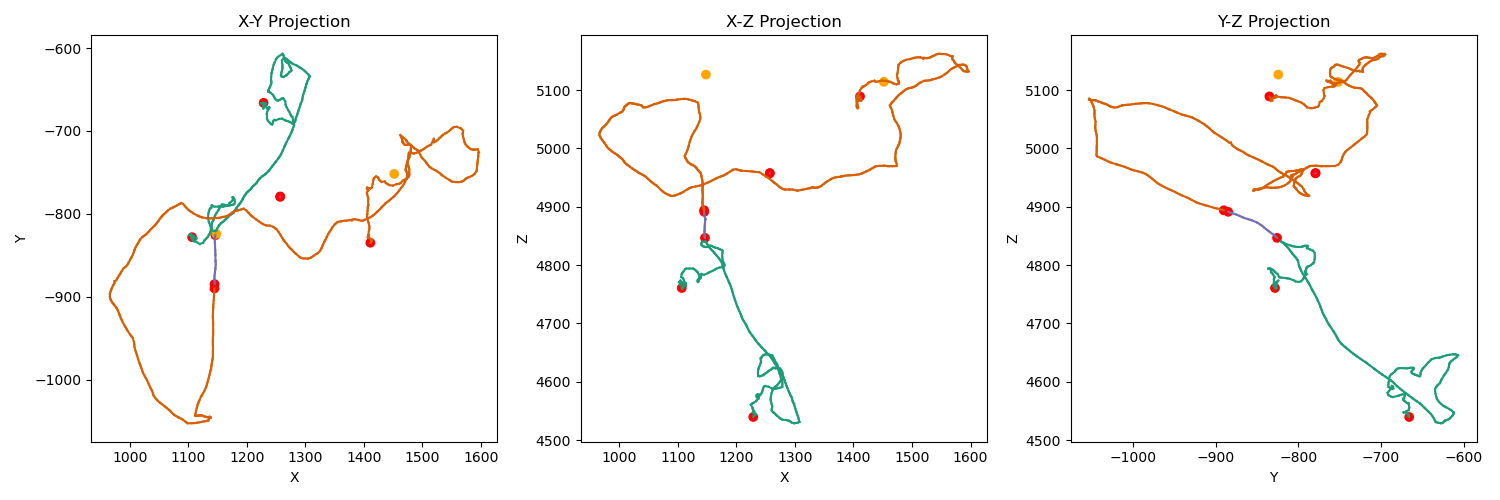

In [69]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]


Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, Tracks_):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0 or count == 3]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # # Define colors for filtered data
    colors = [None] * len(filtered_indices)
    for index, i in enumerate(filtered_indices):
        if connection_count[i] == 1:
            colors[index] = "r"
        elif (connection_count[i] == 0):
            colors[index] = "Orange"
        else:
            colors[index] = "DarkGreen"

    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in Tracks_:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [70]:
print(GetMedianNodeDist(Tracks, data))

dist_threshold = 4*GetMedianNodeDist(Tracks, data)
print("Dist Thresh",dist_threshold)

3.292
Dist Thresh 13.168


In [71]:
# Now look to merge tracks that are close by and identify deltas

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)


In [72]:

finished = False  # Initial state

q = 0
while not finished:
    print("Loop: ", q)
    # finished, Tracks2 = ConnectTracks(Tracks2, temp_connections_dict, temp_connections, temp_connection_count)
    finished, Tracks, connected_nodes, connections, connection_count = ConnectTracks(Tracks, connected_nodes, connections, connection_count, dist_matrix, dist_threshold, data)
    q=q+1

print(finished)

print("Total Tracks:", len(Tracks))

for t in Tracks:
    print(t)



Loop:  0
Loop:  1
Loop:  2
True
Total Tracks: 5
{'id': 5, 'start': 538, 'end': 539, 'nodes': [538, 539], 'length': 0.63, 'energy': 0.030032800510525703, 'label': 'track', 'c': (0.9058823529411765, 0.1607843137254902, 0.5411764705882353)}
{'id': 6, 'start': 327, 'end': 327, 'nodes': [327], 'length': 0, 'energy': 0.021278399974107742, 'label': 'gamma', 'c': 'y'}
{'id': 7, 'start': 794, 'end': 794, 'nodes': [794, 796], 'length': 0, 'energy': 0.004488800186663866, 'label': 'gamma', 'c': 'black'}
{'id': 9, 'start': 324, 'end': 154, 'nodes': [324, 268, 264, 261, 266, 292, 294, 299, 315, 329, 334, 336, 339, 342, 346, 350, 355, 361, 364, 368, 373, 378, 376, 375, 377, 381, 386, 388, 390, 387, 384, 372, 366, 358, 354, 347, 341, 338, 332, 300, 263, 260, 253, 248, 242, 235, 230, 226, 225, 236, 245, 249, 254, 256, 247, 244, 233, 224, 222, 216, 212, 209, 205, 194, 180, 172, 167, 160, 157, 153, 151, 161, 164, 178, 177, 168, 158, 147, 144, 148, 146, 155, 163, 166, 162, 156, 154], 'length': 303.978, 'e

{'id': 0, 'start': 452, 'end': 757, 'length': 2963.167, 'energy': 2.07938079458836, 'label': 'Primary', 'c': 'Teal', 'nodes': [452, 455, 459, 464, 463, 457, 458, 451, 450, 453, 446, 445, 441, 444, 447, 454, 465, 468, 472, 482, 486, 483, 484, 473, 470, 467, 469, 474, 490, 494, 502, 506, 509, 513, 518, 522, 534, 554, 574, 583, 596, 608, 627, 628, 629, 632, 631, 633, 625, 623, 615, 612, 604, 595, 589, 581, 578, 568, 561, 547, 536, 532, 528, 526, 519, 514, 512, 507, 491, 478, 477, 476, 479, 480, 485, 488, 492, 497, 498, 496, 495, 499, 500, 503, 505, 510, 515, 523, 527, 533, 559, 553, 564, 570, 573, 579, 586, 590, 594, 598, 601, 606, 610, 614, 620, 618, 611, 602, 592, 587, 584, 576, 566, 560, 548, 545, 542, 543, 546, 549, 557, 558, 555, 552, 550, 565, 567, 572, 582, 588, 593, 605, 613, 619, 630, 644, 648, 651, 656, 659, 667, 672, 679, 683, 682, 681, 680, 678, 675, 674, 673, 671, 670, 668, 666, 665, 664, 663, 661, 660, 658, 657, 655, 653, 652, 649, 647, 646, 645, 643, 641, 640, 638, 636, 637

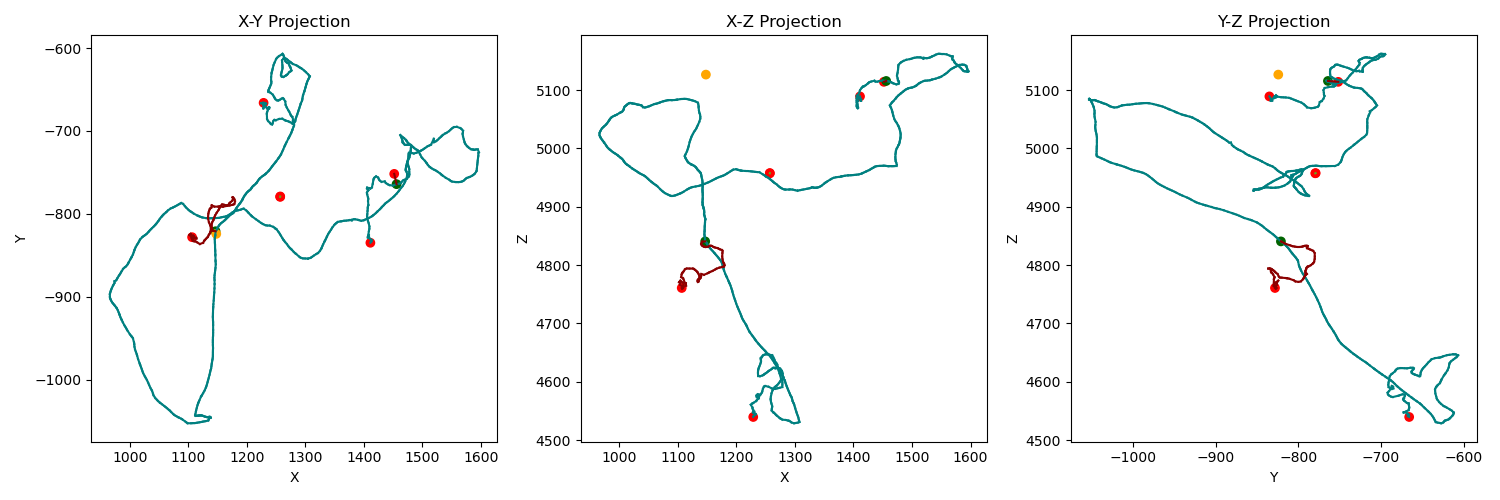

In [73]:


RebuiltTrack, pass_flag = RebuildTracks(connected_nodes, connection_count, data)

for t in RebuiltTrack:
    print(t)

print(pass_flag)


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', RebuiltTrack)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', RebuiltTrack)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', RebuiltTrack)

# axs[0].scatter(data["x"].iloc[25], data["y"].iloc[25])

plt.tight_layout()
plt.show()



In [74]:
# Get the track with the most nodes, this is taken to be the primary

num_nodes = 0
primary_track_id = -1
primary_nodes = []

for t in RebuiltTrack:
    if ( len(t["nodes"]) > num_nodes):
        num_nodes = len(t["nodes"])
        primary_track_id = t["id"]
        primary_nodes = t["nodes"]

print("The primary track is: ", primary_track_id)

# This list makes sure we only have one angle per node
all_visited = []

Primary_Track = data.reindex(primary_nodes)
Primary_Track = GetAnglesDF(Primary_Track, all_visited, 1, primary_track_id)
all_visited = all_visited + primary_nodes

df_angles = pd.DataFrame()
df_angles = pd.concat([df_angles, Primary_Track], ignore_index=True)

for t in RebuiltTrack:

    trk_nodes = t["nodes"]
    if t["id"] == primary_track_id:
        continue
    else:
        
        # See if the first/last node has three connections. If it does then flip the track
        con_end = connection_count[t["nodes"][-1]]
        if (con_end == 3):
            trk_nodes = trk_nodes[::-1]
        
        trk = data.reindex(trk_nodes)

        trk = GetAnglesDF(trk, all_visited, 0, t["id"])
        all_visited = all_visited + trk_nodes
        df_angles = pd.concat([df_angles, trk], ignore_index=True)


# Primary_Track.reset_index(drop=True, inplace=True)
pd.set_option('display.max_rows', 100)
display(df_angles)

print(connected_nodes)



The primary track is:  0


,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle
0,304,1228.708496,-666.057251,4539.678223,0.053890,2,452,1,0,0.000000,0.000000
1,304,1229.242920,-667.619812,4541.291992,0.002926,2,455,1,0,2.308995,153.674525
2,304,1231.570557,-666.499817,4543.069824,0.003174,2,459,1,0,5.444751,70.952821
3,304,1232.870483,-666.984131,4544.137695,0.003596,2,464,1,0,7.195385,37.040473
4,304,1232.567871,-667.552063,4544.982422,0.000025,2,463,1,0,8.257310,65.065344
...,...,...,...,...,...,...,...,...,...,...,...
966,304,1106.531982,-828.170654,4760.738281,0.010218,2,154,0,1,303.977839,89.672698
967,304,1451.889648,-751.765991,5113.990234,0.004489,2,794,0,2,13.137518,179.999999
968,304,1147.832764,-824.184082,5126.391602,0.021278,0,327,0,3,0.000000,0.000000
969,304,1256.990967,-779.511292,4957.257812,0.019270,1,538,0,4,0.000000,0.000000


{0: [3, 1], 3: [0, 5], 1: [2, 0], 2: [1, 4], 4: [2, 7], 5: [3, 6], 6: [5, 8], 7: [4, 9], 8: [6, 10], 9: [11, 7], 11: [9, 13], 10: [12, 8], 12: [10, 15], 13: [16, 11], 16: [13, 18], 14: [15, 17], 15: [14, 12], 17: [20, 14], 20: [17, 21], 18: [19, 16], 19: [18, 22], 21: [20, 24], 22: [19, 23], 23: [25, 22], 25: [23, 26], 24: [27, 21], 27: [24, 28], 26: [25, 29], 28: [27, 30], 29: [26, 31], 30: [28, 34], 31: [32, 29], 32: [31, 33], 33: [32, 35], 34: [36, 30], 36: [34, 38], 35: [37, 33], 37: [35, 39], 38: [36, 41], 39: [37, 40], 40: [39, 44], 41: [42, 38], 42: [41, 43], 43: [42, 45], 44: [46, 40], 46: [44, 49], 45: [47, 43], 47: [45, 48], 49: [46, 51], 48: [47, 50], 50: [48, 52], 51: [49, 53], 52: [56, 50], 56: [52, 58], 53: [54, 51], 54: [53, 55], 55: [54, 57], 58: [56, 60], 57: [55, 59], 59: [61, 57], 61: [59, 62], 60: [63, 58], 63: [60, 64], 62: [61, 65], 65: [62, 66], 64: [63, 67], 66: [65, 68], 67: [69, 64], 69: [67, 72], 68: [70, 66], 70: [68, 71], 72: [69, 75], 71: [70, 73], 73: [71

Text(0, 0.5, 'Scatter Angle [deg]')

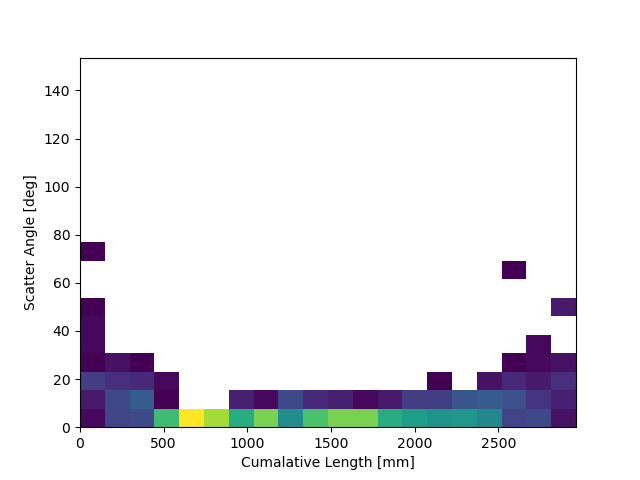

In [75]:
plt.figure()
# plt.scatter(Primary_Track.x, Primary_Track.z)

# plt.scatter(Primary_Track.index, Primary_Track.angle)

# plt.hist(Primary_Track.angle)
# plt.semilogy()
plt.hist2d(Primary_Track.cumulative_distance, Primary_Track.angle, bins = 20,cmin=3);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle)

plt.xlabel("Cumalative Length [mm]")
plt.ylabel("Scatter Angle [deg]")

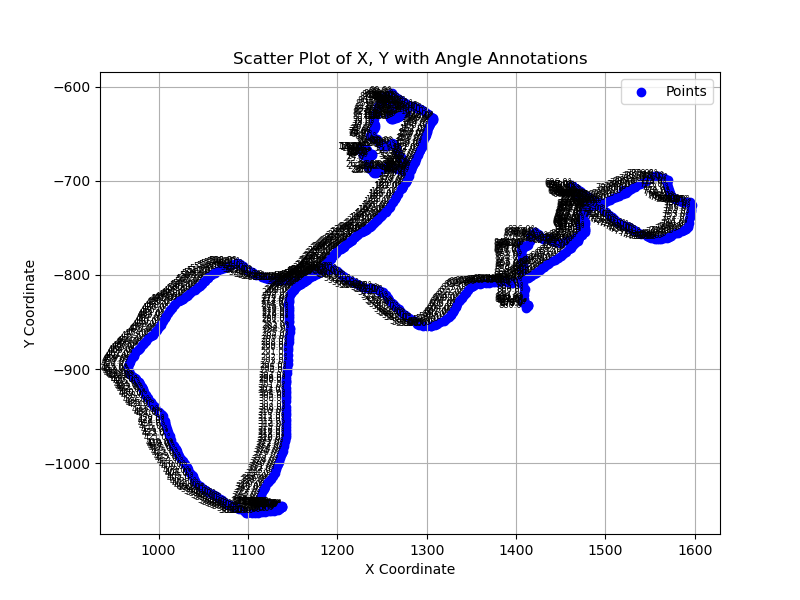

In [76]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Primary_Track['x'], Primary_Track['y'], color='blue', label='Points')

# Annotate each point with the corresponding angle
for i in range(len(Primary_Track)):
    x = Primary_Track.iloc[i]['x']
    y = Primary_Track.iloc[i]['y']
    # angle = Primary_Track.loc[i, 'angle']
    angle = i
    
    # Only annotate if angle is not NaN
    if not np.isnan(angle):
        plt.text(x, y, f'{angle:.1f}°', fontsize=6, ha='right')

# Additional plot settings
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of X, Y with Angle Annotations')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [77]:
# Calculate Track Tortuosity

df_angles = CalcAngularVars(df_angles, Tortuosity_dist)

In [78]:
display(df_angles)

,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
0,304,1228.708496,-666.057251,4539.678223,0.053890,2,452,1,0,0.000000,0.000000,1.759065,2.146808
1,304,1229.242920,-667.619812,4541.291992,0.002926,2,455,1,0,2.308995,153.674525,1.844318,2.313679
2,304,1231.570557,-666.499817,4543.069824,0.003174,2,459,1,0,5.444751,70.952821,1.844318,2.313679
3,304,1232.870483,-666.984131,4544.137695,0.003596,2,464,1,0,7.195385,37.040473,1.844318,2.313679
4,304,1232.567871,-667.552063,4544.982422,0.000025,2,463,1,0,8.257310,65.065344,1.844318,2.313679
...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,304,1106.531982,-828.170654,4760.738281,0.010218,2,154,0,1,303.977839,89.672698,2.856186,2.240232
967,304,1451.889648,-751.765991,5113.990234,0.004489,2,794,0,2,13.137518,179.999999,1.000000,0.000000
968,304,1147.832764,-824.184082,5126.391602,0.021278,0,327,0,3,0.000000,0.000000,1.000000,0.000000
969,304,1256.990967,-779.511292,4957.257812,0.019270,1,538,0,4,0.000000,0.000000,1.000000,0.000184


Text(0, 0.5, 'Angle [deg]')

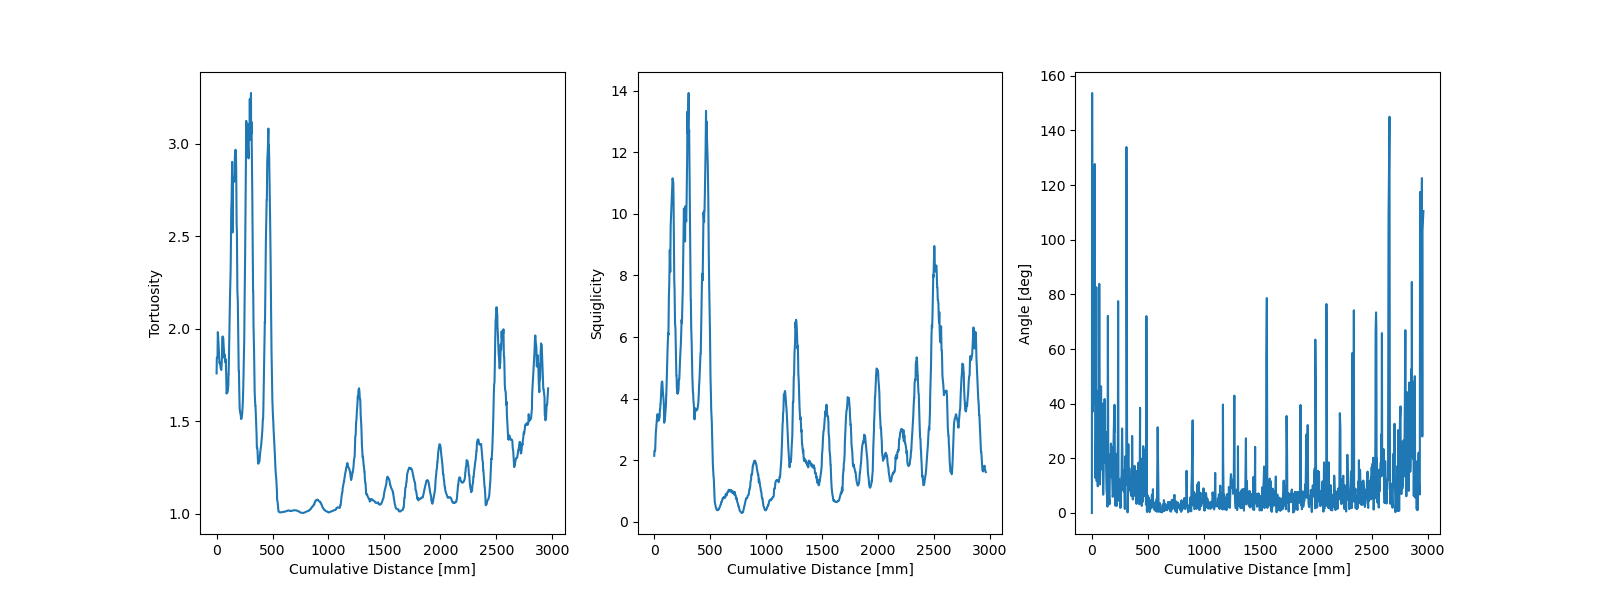

In [79]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs[0].plot(df_angles[df_angles.trkID == 0].cumulative_distance, df_angles[df_angles.trkID == 0]["Tortuosity"])
axs[0].set_xlabel("Cumulative Distance [mm]")
axs[0].set_ylabel("Tortuosity")

axs[1].plot(df_angles[df_angles.trkID == 0].cumulative_distance, df_angles[df_angles.trkID == 0]["Squiglicity"])
axs[1].set_xlabel("Cumulative Distance [mm]")
axs[1].set_ylabel("Squiglicity")


axs[2].plot(df_angles[df_angles.trkID == 0].cumulative_distance, df_angles[df_angles.trkID == 0]["angle"])
axs[2].set_xlabel("Cumulative Distance [mm]")
axs[2].set_ylabel("Angle [deg]")

In [80]:
Track_df = GetTrackdf(df_angles, RebuiltTrack, 500, 180, 200, 1) # scale these params inversely with the pressure

display(Track_df)

print(Track_df.energy.sum())



,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label
0,304,0,1,452,757,2963.167,2.079381,0.503192,0.565986,0.590215,0.722697,2.092715,1.671575,5.196265,3.936625,Primary
0,304,1,0,324,154,303.978,0.329418,0.329418,0.329418,0.000000,0.329418,1.859714,2.382491,5.470468,5.795727,Delta0
0,304,2,0,796,794,13.138,0.004489,0.004489,0.004489,0.000000,0.004489,0.000000,0.000000,0.000000,0.000000,Delta0
0,304,3,0,327,327,0.000,0.021278,0.021278,0.021278,0.021278,0.021278,0.000000,0.000000,0.000000,0.000000,Brem
0,304,4,0,538,539,0.630,0.030033,0.030033,0.030033,0.030033,0.030033,1.000000,1.000000,0.000184,0.000184,Brem


2.4645991923171096


In [81]:

Track_df_u = UpdateTrackMeta(Track_df, df_angles, 100)

display(Track_df_u)


Adding trk 2 Delta0 energy to blob2 as dist was 87.76371765136719
Swapping the blob names


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label
0,304,0,1,757,452,2963.167,2.079381,0.570474,0.503192,0.727186,0.590215,1.671575,2.092715,3.936625,5.196265,Primary
0,304,1,0,324,154,303.978,0.329418,0.329418,0.329418,0.000000,0.329418,1.859714,2.382491,5.470468,5.795727,Delta0
0,304,2,0,796,794,13.138,0.004489,0.004489,0.004489,0.000000,0.004489,0.000000,0.000000,0.000000,0.000000,Delta0
0,304,3,0,327,327,0.000,0.021278,0.021278,0.021278,0.021278,0.021278,0.000000,0.000000,0.000000,0.000000,Brem
0,304,4,0,538,539,0.630,0.030033,0.030033,0.030033,0.030033,0.030033,1.000000,1.000000,0.000184,0.000184,Brem
